In [27]:
import pandas as pd
import os
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from sklearn.naive_bayes import MultinomialNB
import sklearn.feature_extraction.text as sk_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator, RegressorMixin
from wordcloud import WordCloud
import numpy as np
import re
from nltk.stem import PorterStemmer

We will first read the .csv files for the first and the second Presidential debate of 2020. Then we will combine these files by merging them.

In [28]:
path = '/Users/nikhil/data/ML_examples/erdos/'

election_df_1 = pd.read_csv(path+'us_election_2020_1st_presidential_debate.csv')
election_df_2 = pd.read_csv(path+'us_election_2020_2nd_presidential_debate.csv')
election_df = pd.concat([election_df_1,election_df_2],axis=0)
election_df[:5]

,speaker,minute,text
0,Chris Wallace,01:20,Good evening from the Health Education Campus ...
1,Chris Wallace,02:10,This debate is being conducted under health an...
2,Vice President Joe Biden,02:49,"How you doing, man?"
3,President Donald J. Trump,02:51,How are you doing?
4,Vice President Joe Biden,02:51,I’m well.


Perform a train test split

In [29]:
train_election,test_election = train_test_split(election_df.copy(),test_size=0.2, random_state=42)

Lets define the column transformer class. The column transformer will select only those rows from the data frame where the speaker is Joe Biden and Donald Trump (We will ignore text from Chris Wallace as he is the mediator). The column transformer will then add a target column to the data frame. The value in the target column for rows with speaker as Joe Biden  will be 1 and the value in the target column for rows with speaker as Donald Trump will be 0 (1 indicating that the candiddate got elected as the President and 0 otherwise).

In [30]:
class Custom_Transformer(BaseEstimator, TransformerMixin):
    '''speaker_1: Name of Presidential candidate 1 (string)
       speaker_2: Name of Presidential candidate 2 (string)
       target_1 : Target class of speaker 1(0 or 1) (int)
       target_2 : Target class of speaker 2(0 or 1) (int)'''
    def __init__(self,speaker_1,speaker_2,target_1,target_2):
        self.speaker_1 = speaker_1
        self.speaker_2 = speaker_2
        self.target_1 = target_1
        self.target_2 = target_2
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        df_speaker1 = X[X['speaker']==self.speaker_1]
        df_speaker2 = X[X['speaker']==self.speaker_2]
        df_target_1 = pd.DataFrame(len(df_speaker1)*[self.target_1],index=df_speaker1.index)
        df_target_2 = pd.DataFrame(len(df_speaker2)*[self.target_2],index=df_speaker2.index)
        df_speaker1 = df_speaker1.assign(target=df_target_1)
        df_speaker2 = df_speaker2.assign(target=df_target_2)
        df_concat = pd.concat([df_speaker1,df_speaker2],axis=0)
        return df_concat
    
def stemming_tokenizer(input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", input).lower().split()
    words = [word.replace("-","") for word in words]
    words = [PorterStemmer().stem(word) for word in words]
    return words

In [31]:
Transformer = Custom_Transformer('Vice President Joe Biden','President Donald J. Trump',1,0)

df_new_train = Transformer.fit_transform(train_election)
df_new_test =  Transformer.fit_transform(test_election)

df_new_train[:5]

,speaker,minute,text,target
536,Vice President Joe Biden,35:20,"Law and order with justice, where people get t...",1
348,Vice President Joe Biden,18:53,"By the way, I’m going to eliminate a significa...",1
135,Vice President Joe Biden,17:15,Sure.,1
309,Vice President Joe Biden,15:16,Show us your tax returns.,1
367,Vice President Joe Biden,20:45,He blew it.,1


Define the TF-IDF vectorizer by using ngrams = (1,1) for unigrams and ngrams = (2,2) for bigrams.

In [32]:
bigrams = False
if bigrams:
   ngrams = (2,2)
else:
   ngrams = (1,1)
   
Tfidf = sk_text.TfidfVectorizer(lowercase=True,analyzer='word',stop_words= 'english',ngram_range=ngrams,tokenizer=stemming_tokenizer)

Separate the X and y for training and test data set. X is the 'text' column and y is the 'target' column.

In [33]:
X = df_new_train['text']
y = df_new_train['target']
X_test = df_new_train['text']
y_test = df_new_train['target']
X[:5]

536    Law and order with justice, where people get t...
348    By the way, I’m going to eliminate a significa...
135                                                Sure.
309                            Show us your tax returns.
367                                          He blew it.
Name: text, dtype: object

Lets generate a pipeline called Voting_classifier. The pipeline will initially convert the 'text' column from the input data to a sparse matrix of words using the TF-IDF vectorizer and feed that sparse matrix to sklearn's Multinomial Naive Bayes estimator. The Pipeline function is very useful when we are dealing with huge NLP data sets which require a lot of preprocessing before feeding it to the model. The Pipeline function can also be used for hyper-parametrer tuning using MyGridSearchCV.

In [34]:
Voting_classifier = Pipeline([("Tfidf vectorizer",Tfidf),("Multinomial NB",MultinomialNB())])

Fit the Voting_classifier to the train data and make predictions on the test data.

In [35]:
Voting_classifier.fit(X,y)
y_predict = Voting_classifier.predict(X_test)

/Users/nikhil/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words

Some metrics

/Users/nikhil/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


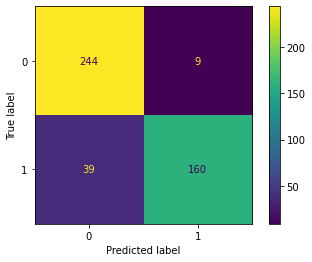

In [36]:
plot_confusion_matrix(Voting_classifier, X_test, y_test)

During training, the multinomial naive bayes calculates probabilities such as $Pr(\textrm{'Great'}\ |\ \textrm{Win}),$ the probability that the word "Great" appears in the candidate's speech, given that the candidate has won the election.  Using these probabilities, we can define a **polarity score** for each word $w$,

$$\textrm{polarity}(w) = \log\left(\frac{Pr(w\ |\ \textrm{won})}{Pr(w\ |\ \textrm{lost})}\right).$$

Polarity analysis is an example where a simpler model (naive Bayes) offers more explicability than more complicated models.  Aside from this, naive Bayes models are easy to train, the training process is parallelizable, and these models lend themselves well to online learning.  Given enough training data, naive Bayes models have performed well in NLP applications such as spam filtering.

Speaking in terms of python code, the command  "**voting_classifier['Tfidf vectorizer'].get_feature_names_out()**"  will give you a list of filtered words that were used as features in the multinomial naive bayes method. We can get **$\log(Pr(w\ |\ \textrm{won}))$** and **$\log(Pr(w\ |\ \textrm{lost}))$** by using the sklearn's "**model.feature_log_prob**" command as follows,

$\log(Pr(w\ |\ \textrm{won}))$ = classifier['Multinomial NB'].feature_log_prob_[1]

$\log(Pr(w\ |\ \textrm{lost}))$ = classifier['Multinomial NB'].feature_log_prob_[0]

Using this, we can calculate the polarity score for all the words.

Some of the words that the TF-IDF vectorizer uses as features are given below

In [37]:
words = Voting_classifier['Tfidf vectorizer'].get_feature_names_out()

print(words[500:600])

['ground' 'group' 'grow' 'growth' 'guarante' 'guess' 'guy' 'h1n1' 'ha'
 'half' 'hand' 'handl' 'hanger' 'happen' 'happi' 'hard' 'hasn' 'hate'
 'hatr' 'haven' 'head' 'health' 'healthcar' 'hear' 'heard' 'heart' 'heat'
 'heavili' 'held' 'hell' 'help' 'hero' 'hey' 'hi' 'high' 'higher'
 'highest' 'highli' 'highway' 'hillari' 'histori' 'hit' 'hoax' 'hold'
 'hole' 'home' 'homeland' 'honest' 'honor' 'hope' 'horribl' 'hospit'
 'hotel' 'hour' 'hous' 'hundr' 'hunter' 'hurrican' 'hurt' 'idea' 'ignit'
 'imagin' 'impeach' 'import' 'importantli' 'incent' 'includ' 'incom'
 'increas' 'incred' 'india' 'individu' 'industri' 'infect' 'infrastructur'
 'inherit' 'inject' 'insan' 'insensit' 'insist' 'instead' 'insulin'
 'insult' 'insur' 'intent' 'invest' 'iowa' 'iraq' 'irish' 'irrespons'
 'issu' 'iwillvot' 'jail' 'japan' 'jersey' 'job' 'joe' 'johnson' 'join'
 'judg']


In [38]:
def get_polar_words(classifier,top):
    coeff_pos = classifier['Multinomial NB'].feature_log_prob_[1]
    coeff_neg = classifier['Multinomial NB'].feature_log_prob_[0]
    words = classifier['Tfidf vectorizer'].get_feature_names_out()
    words_join=[]
    for w in words:
        words_join.append(w.replace(" ", "_"))
    words_join = np.array(words_join)
    polarity = coeff_pos-coeff_neg
    polarity_sorted = np.sort(polarity)
    index_sort = np.argsort(polarity)
    words_sorted = words_join[index_sort]
    words_positive = words_sorted[-top:]
    words_negative = words_sorted[:top]
    wc1 = WordCloud(width = 1000, height = 500).generate(" ".join(words_positive))
    wc2 = WordCloud(width = 1000, height = 500).generate(" ".join(words_negative))
    return wc1,wc2,words_join


Lets plot the top 50 most polar words

[]

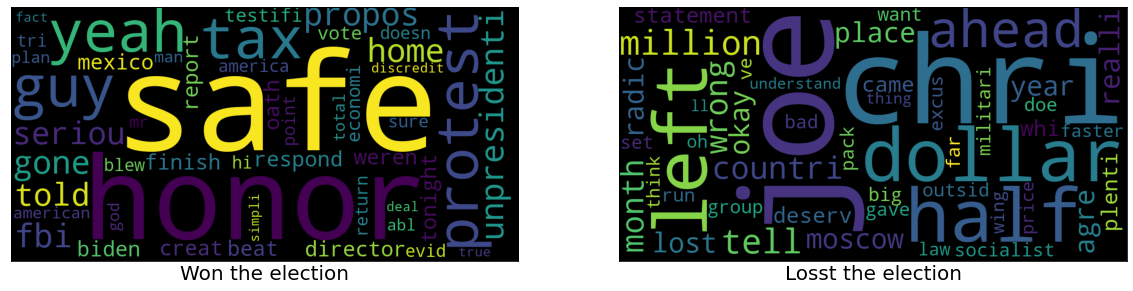

In [44]:
wc1,wc2,feature_names = get_polar_words(Voting_classifier,50)

f = plt.figure(figsize=(20,10))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.imshow(wc1)
ax1.set_xlabel('Won the election',fontsize=20)
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(wc2)
ax2.set_xlabel('Losst the election',fontsize=20)
ax2.set_xticks([])
ax2.set_yticks([])

